# Reports

- List of KPIs to be resolved:

  - [1](#no1): What's the number of jobs posting per category (Top 10)? 
  - [2](#no2): What's the salary distribution per job category? 
  - [3](#no3): Is there any correlation between the higher degree and the salary?
  - [4](#no4): What's the job posting having the highest salary per agency? 
  - [5](#no5): What's the job postings average salary per agency for the last 2 years? 
  - [6](#no6): What are the highest paid skills in the US market? 

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

In [6]:
df = spark.read.parquet('/dataset/df_final')
df.printSchema()


root
 |-- JobID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- JobCategory: string (nullable = true)
 |-- PreferredSkills: string (nullable = true)
 |-- HourlySalary: float (nullable = true)
 |-- HigherDegree: string (nullable = true)
 |-- PostingDateAdj: date (nullable = true)



In [7]:
from pyspark.sql.functions import col

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

<a id='no1'></a>
# What's the number of jobs posting per category (Top 10)?

In [9]:
df.groupBy('JobCategory').count().orderBy('count', ascending=False).limit(10).show(truncate=False)

+-----------------------------------------+-----+
|JobCategory                              |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |260  |
|Technology, Data & Innovation            |182  |
|Legal Affairs                            |120  |
|Building Operations & Maintenance        |99   |
|Finance, Accounting, & Procurement       |98   |
|Public Safety, Inspections, & Enforcement|98   |
|Administration & Human Resources         |88   |
|Health                                   |71   |
|Constituent Services & Community Programs|68   |
|Policy, Research & Analysis              |64   |
+-----------------------------------------+-----+



In [10]:
top_10_df = df.groupBy('JobCategory').count().orderBy('count', ascending=False).limit(10)

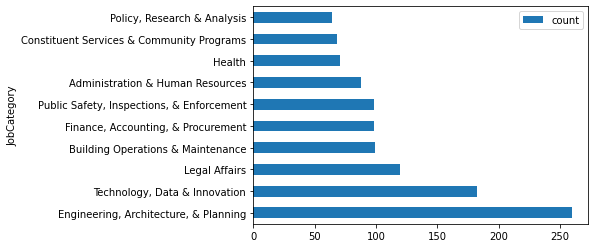

In [17]:
top_10_df.toPandas().plot.barh(x='JobCategory',y='count');

<a id='no2'></a>
# What's the salary distribution per job category?


In [12]:
df.createOrReplaceTempView('temp')

In [13]:
salary_dist_by_job_cat_df = spark.sql('''
select JobCategory,
       max(HourlySalary) as max,
       min(HourlySalary) as min,
       round(avg(HourlySalary),2) as avg
from temp
group by JobCategory 
''')

In [140]:
salary_dist_by_job_cat_df.sort('avg').toPandas()

,JobCategory,max,min,avg
0,Constituent Services & Community Programs Tech...,15.500000,15.500000,15.50
1,Constituent Services & Community Programs Tech...,15.500000,15.500000,15.50
2,Administration & Human Resources Constituent S...,15.500000,15.500000,15.50
3,Communications & Intergovernmental Affairs Pub...,16.740000,16.740000,16.74
4,"Engineering, Architecture, & Planning Finance,...",17.700001,17.700001,17.70
...,...,...,...,...
126,"Engineering, Architecture, & Planning Policy, ...",72.989998,72.989998,72.99
127,"Health Policy, Research & Analysis Public Safe...",92.489998,54.009998,73.25
128,"Engineering, Architecture, & Planning Finance,...",119.290001,103.870003,111.58
129,"Engineering, Architecture, & Planning Maintena...",112.989998,112.989998,112.99


In [134]:
plt.rcParams["figure.figsize"] = (20, 18)

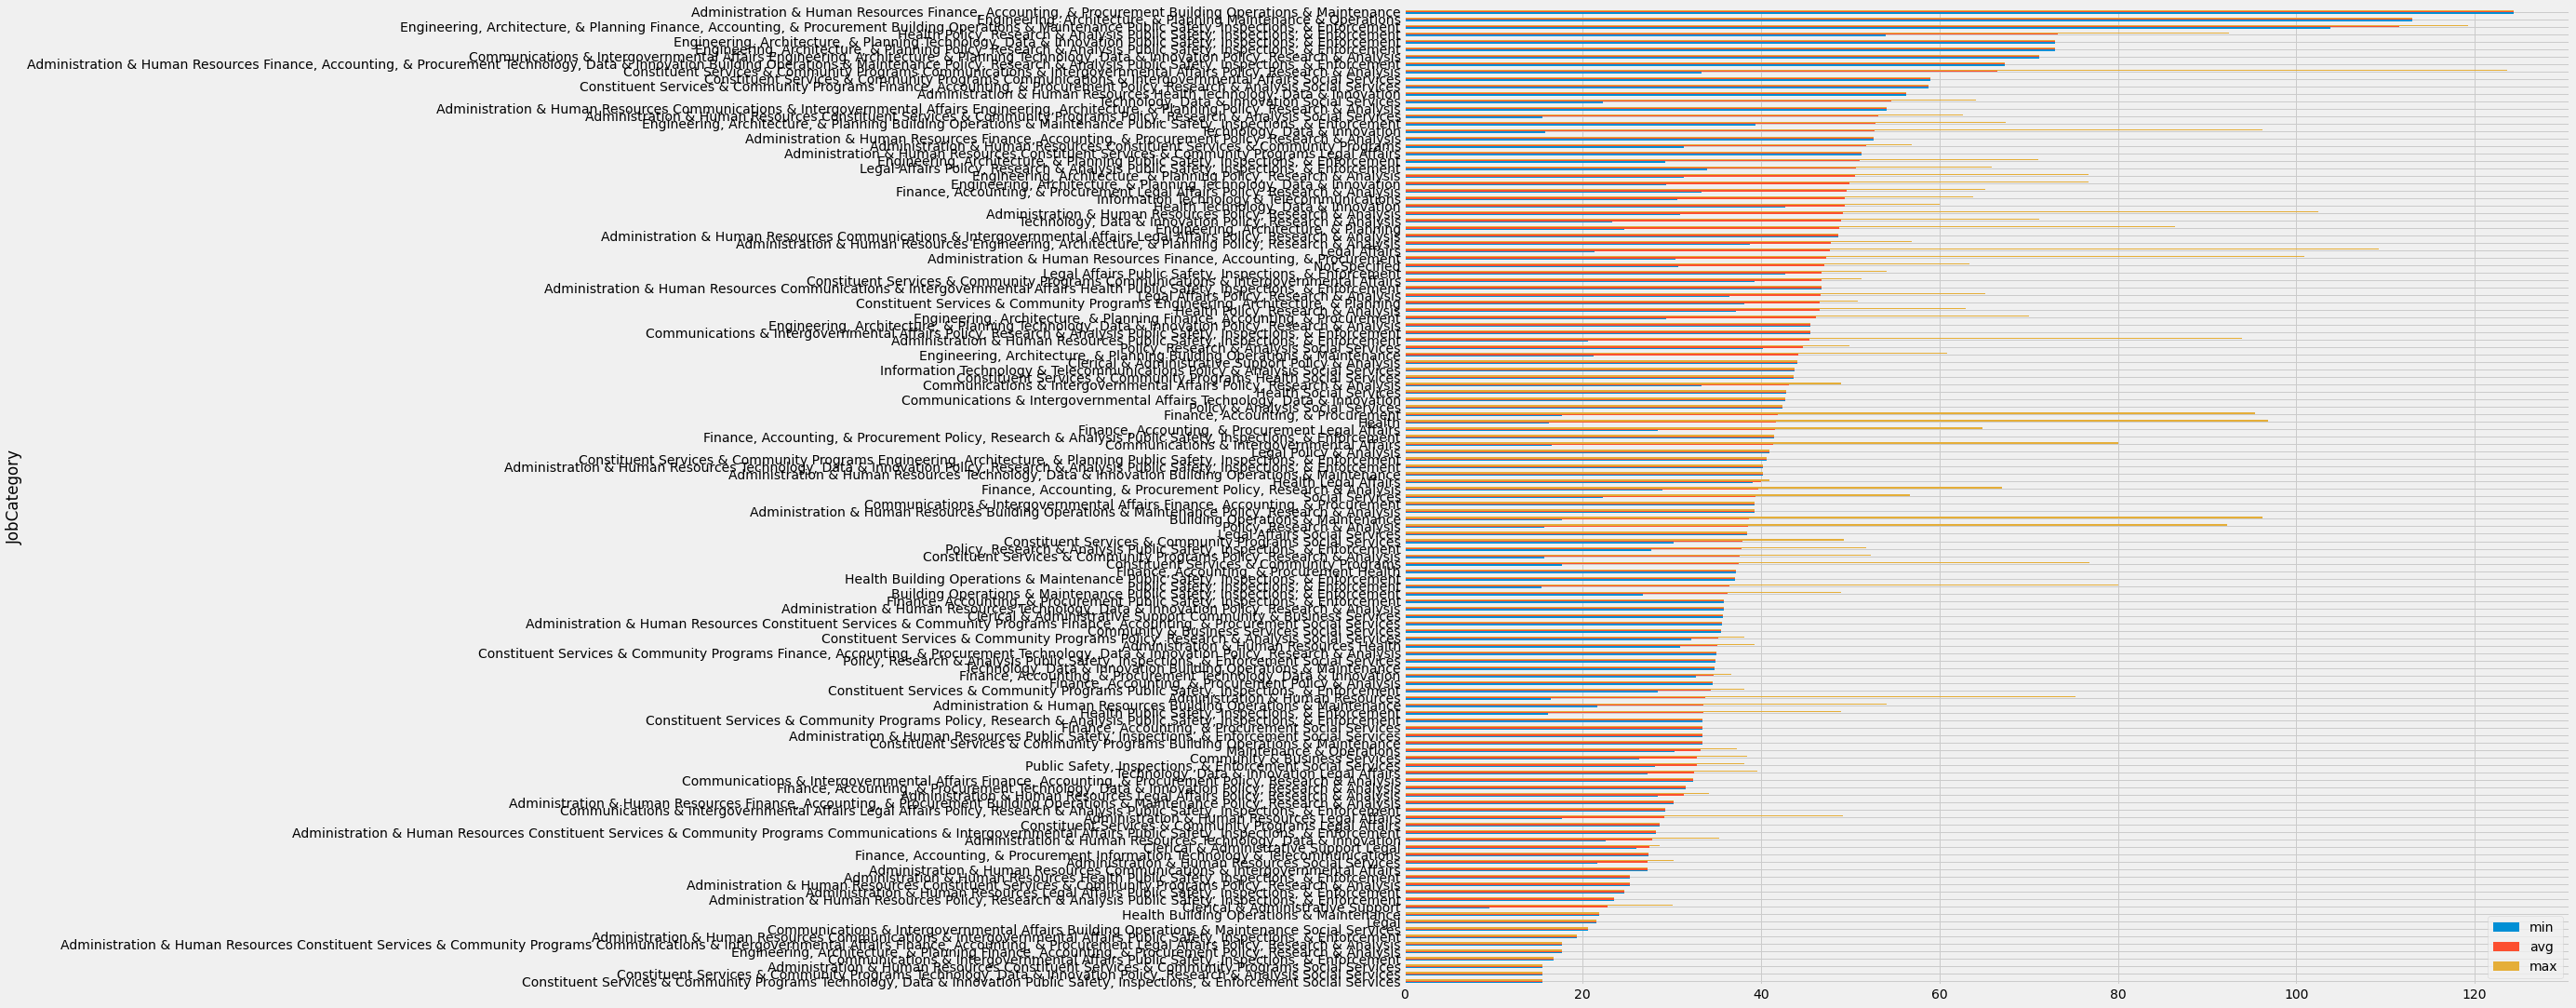

In [135]:
salary_dist_by_job_cat_df.sort('avg').toPandas().plot.barh(x='JobCategory',y=['min','avg','max']);

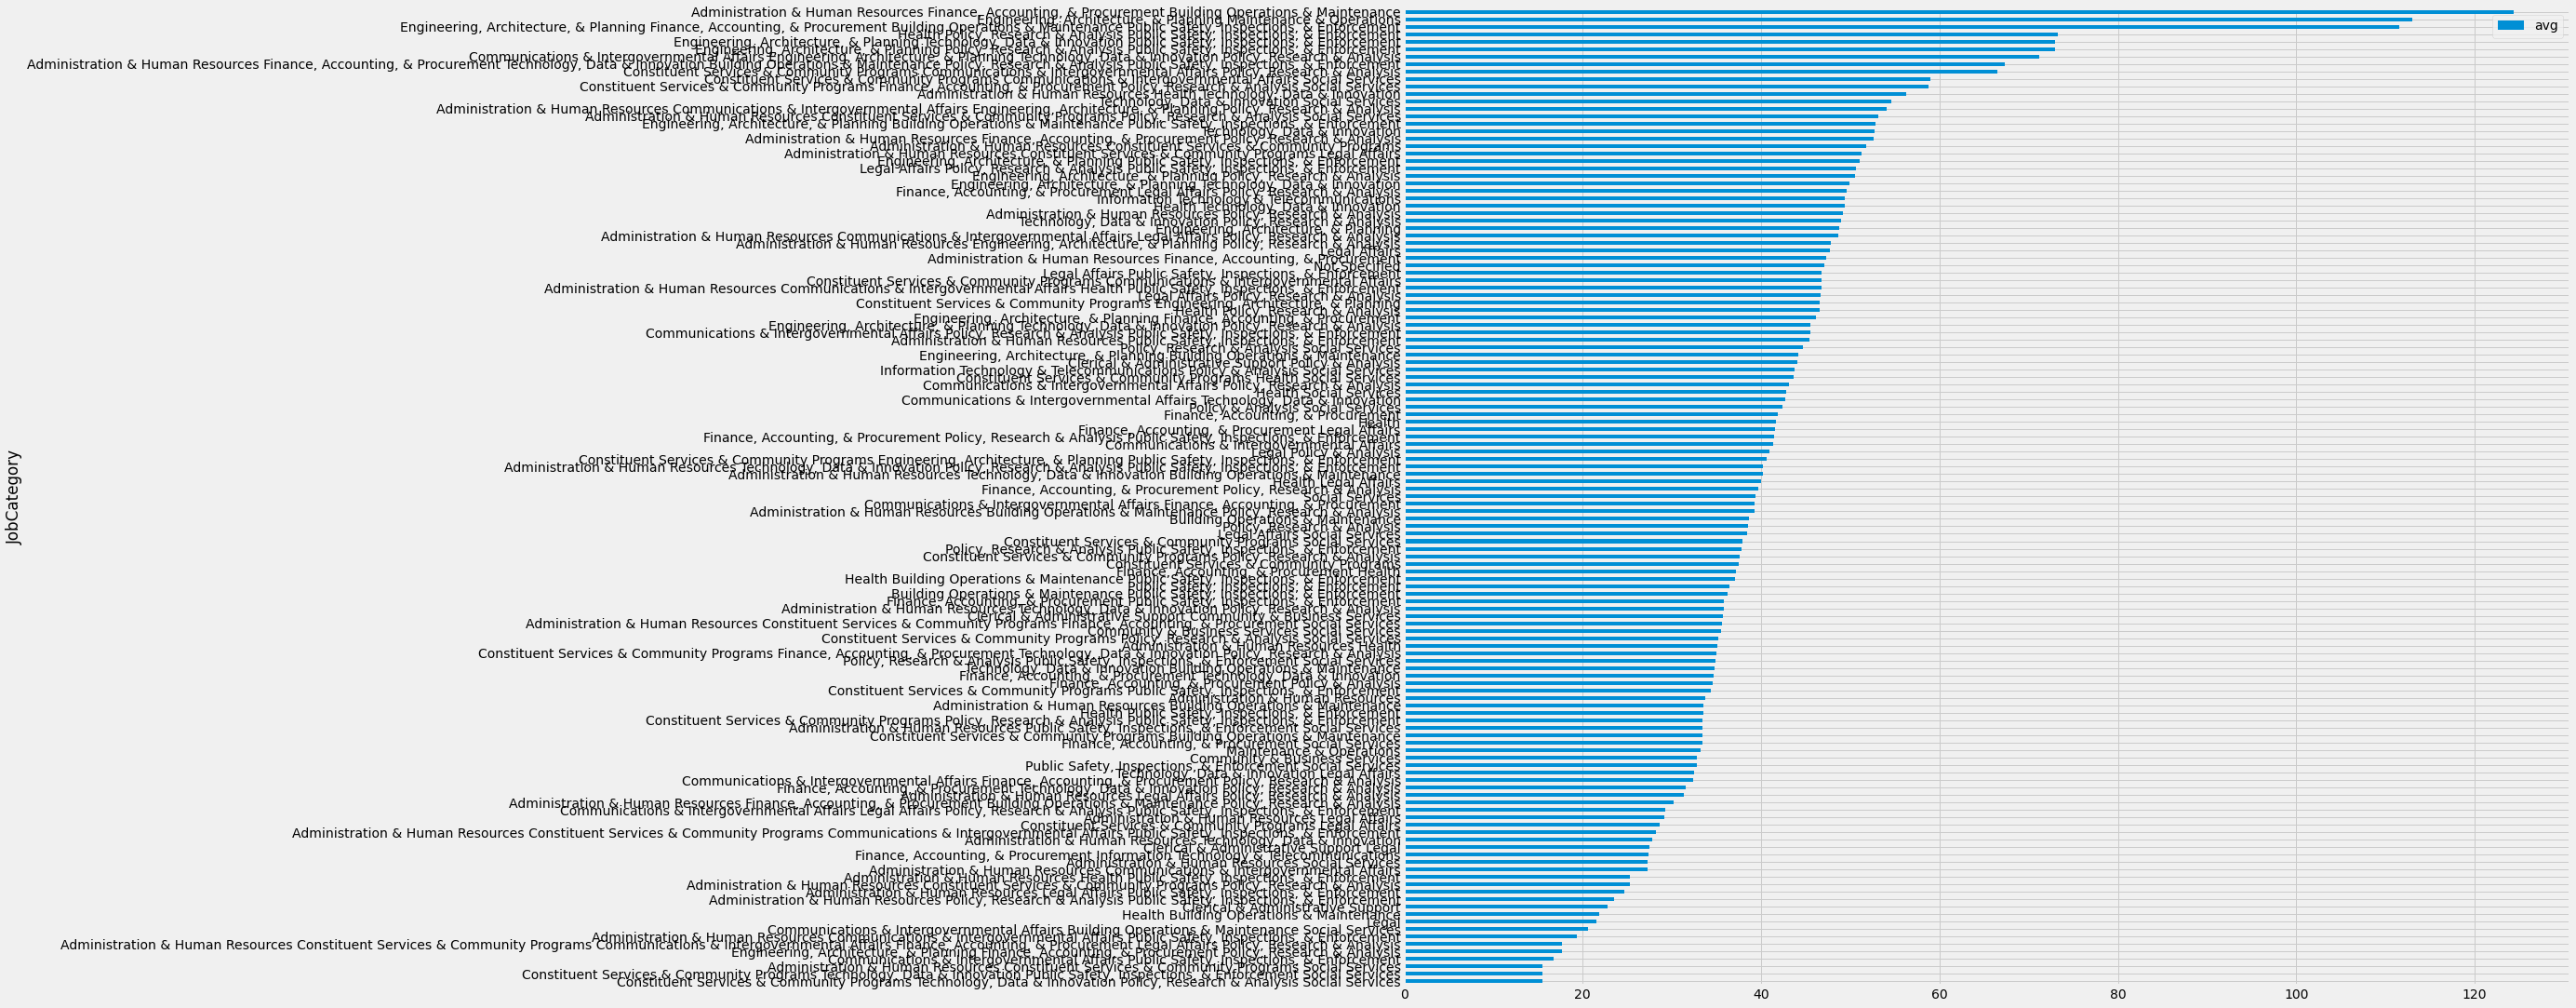

In [136]:
salary_dist_by_job_cat_df.sort('avg').toPandas().plot.barh(x='JobCategory',y='avg');

<a id='no3'></a>
# Is there any correlation between the higher degree and the salary?


In [34]:
from pyspark.sql.functions import mean,min,max,when,col

In [35]:
import pandas as pd

In [37]:
df.groupby("HigherDegree").agg(mean("HourlySalary"),min("HourlySalary"),max("HourlySalary"))

DataFrame[HigherDegree: string, avg(HourlySalary): double, min(HourlySalary): float, max(HourlySalary): float]

From the table above, we can see that the higher the degree level, the higher the Salary.  However Associate level degree has not performed as well as the jobs where a degree was not specified

In [40]:
salary_aggs_df = df.groupby("HigherDegree").\
                    agg(mean("HourlySalary").alias('avg'),\
                        min("HourlySalary").alias('min'),
                        max("HourlySalary").alias('max'))

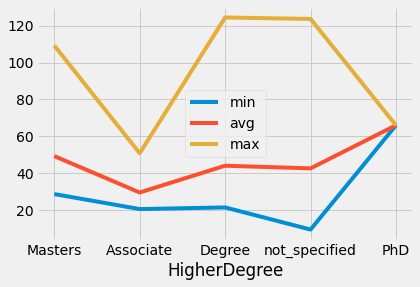

In [43]:
salary_aggs_df.toPandas().plot(x="HigherDegree",y=['min','avg','max']);

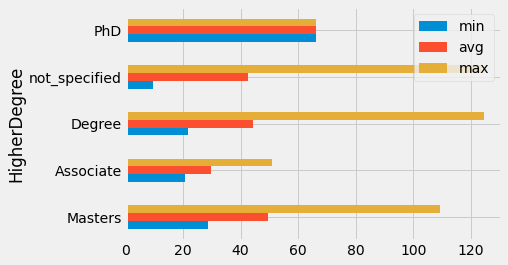

In [46]:
salary_aggs_df.toPandas().plot.barh(x="HigherDegree",y=['min','avg','max']);

In [47]:
salary_aggs_ohc_df = df.select("HourlySalary","HigherDegree")

In [48]:
salary_aggs_ohc_df.printSchema()

root
 |-- HourlySalary: float (nullable = true)
 |-- HigherDegree: string (nullable = true)



In [49]:
salary_aggs_ohc_df.\
                withColumn("Assoc_OHC",
                          when (col("HigherDegree") == "Associate", 1).\
                          otherwise(0)
                        ).\
                withColumn("Degree_OHC",
                          when (col("HigherDegree") == "Degree", 1).\
                          otherwise(0)
                        ).\
                withColumn("Masters_OHC",
                          when (col("HigherDegree") == "Masters", 1).\
                          otherwise(0)
                        ).\
                withColumn("PhD_OHC",
                          when (col("HigherDegree") == "PhD", 1).\
                          otherwise(0)
                        ).\
                withColumn("not_specified_OHC",
                          when (col("HigherDegree") == "not_specified", 1).\
                          otherwise(0)
                        ).\
                withColumn("HigherDegree_OHC",
                           when (col("HigherDegree") != "not_specified", 1).\
                          otherwise(0)
                        ).show()

+------------+-------------+---------+----------+-----------+-------+-----------------+----------------+
|HourlySalary| HigherDegree|Assoc_OHC|Degree_OHC|Masters_OHC|PhD_OHC|not_specified_OHC|HigherDegree_OHC|
+------------+-------------+---------+----------+-----------+-------+-----------------+----------------+
|       35.51|       Degree|        0|         1|          0|      0|                0|               1|
|       46.63|not_specified|        0|         0|          0|      0|                1|               0|
|       30.18|       Degree|        0|         1|          0|      0|                0|               1|
|       53.98|       Degree|        0|         1|          0|      0|                0|               1|
|        56.9|       Degree|        0|         1|          0|      0|                0|               1|
|       55.49|       Degree|        0|         1|          0|      0|                0|               1|
|        65.1|       Degree|        0|         1|      

In [50]:
salary_aggs_ohc_df2 = salary_aggs_ohc_df.\
                withColumn("Assoc_OHC",
                          when (col("HigherDegree") == "Associate", 1).\
                          otherwise(0)
                        ).\
                withColumn("Degree_OHC",
                          when (col("HigherDegree") == "Degree", 1).\
                          otherwise(0)
                        ).\
                withColumn("Masters_OHC",
                          when (col("HigherDegree") == "Masters", 1).\
                          otherwise(0)
                        ).\
                withColumn("PhD_OHC",
                          when (col("HigherDegree") == "PhD", 1).\
                          otherwise(0)
                        ).\
                withColumn("not_specified_OHC",
                          when (col("HigherDegree") == "not_specified", 1).\
                          otherwise(0)
                        ).\
                withColumn("HigherDegree_OHC",
                           when (col("HigherDegree") != "not_specified", 1).\
                          otherwise(0)
                        ).\
                drop("HigherDegree")

In [51]:
ohc_columns = ['Assoc_OHC', 'Degree_OHC', 'Masters_OHC', 'PhD_OHC', 'HigherDegree_OHC', 'not_specified_OHC']
correlations = [ salary_aggs_ohc_df2.stat.corr(ohc, "HourlySalary") for ohc in ohc_columns ]



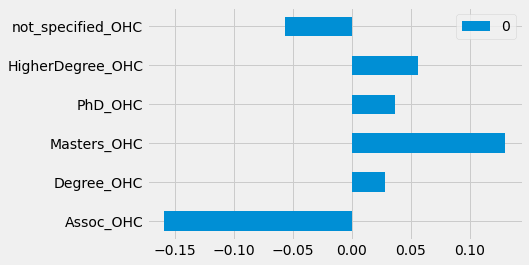

In [118]:
pd.DataFrame(correlations,ohc_columns).plot.barh();

Positive numbers indicate a positive correlation and negative, a negative correlation.  We can see that all degrees above Associate show a positive correlation.  

- HigherDegree_OHC includes all degrees, Assiciate up to and including PhD.

- Have a Masters Degrees seems to have the highest correlation



<a id='no4'></a>
# What's the job posting having the highest salary per agency?


In [110]:
df.createOrReplaceTempView('temp')

In [61]:
spark.sql("""
with v1 as (
    select JobID,
           Agency,
           HourlySalary, 
           max(HourlySalary) over (partition by Agency) as max_sal
    from temp
    )
    select JobID, Agency, HourlySalary
    from v1
    where 
        v1.HourlySalary = max_sal
""").show(100,truncate=False)

+------+------------------------------+------------+
|JobID |Agency                        |HourlySalary|
+------+------------------------------+------------+
|425347|LANDMARKS PRESERVATION COMM   |34.21       |
|170989|OFFICE OF COLLECTIVE BARGAININ|9.55        |
|420216|FIRE DEPARTMENT               |68.57       |
|407253|ADMIN FOR CHILDREN'S SVCS     |66.86       |
|369120|MANHATTAN COMMUNITY BOARD #8  |19.0        |
|423630|TAX COMMISSION                |51.32       |
|424997|HRA/DEPT OF SOCIAL SERVICES   |64.05       |
|413804|TAXI & LIMOUSINE COMMISSION   |79.68       |
|420065|EQUAL EMPLOY PRACTICES COMM   |38.69       |
|97899 |DEPARTMENT OF BUSINESS SERV.  |63.39       |
|416442|DEPT OF DESIGN & CONSTRUCTION |86.39       |
|420740|TEACHERS RETIREMENT SYSTEM    |39.32       |
|423322|DEPARTMENT OF CORRECTION      |78.26       |
|424356|FINANCIAL INFO SVCS AGENCY    |76.84       |
|417137|OFFICE OF EMERGENCY MANAGEMENT|40.41       |
|423210|HOUSING PRESERVATION & DVLPMNT|76.84  

<a id='no5'></a>
# What's the job postings average salary per agency for the last 2 years?

I am making the assumption there that the request is for the last two reported year.   Otherwise we have no rows as the dataset is more than 2 years old.

Please see my [Posting Date analysis](data_analysis.ipynb#posting_date_analysis) and [Posting Date processing](pre_processing_and_wrangling.ipynb#posting_date_processing)


In [ ]:
df.createOrReplaceTempView('temp')

In [87]:
from pyspark.sql.functions import year,current_date

In [62]:
df.show()

+------+--------------------+--------------------+--------------------+------------+-------------+--------------+
| JobID|              Agency|         JobCategory|     PreferredSkills|HourlySalary| HigherDegree|PostingDateAdj|
+------+--------------------+--------------------+--------------------+------------+-------------+--------------+
|239052|ADMIN FOR CHILDRE...|Community & Busin...|" all candidates ...|       35.51|       Degree|    1900-01-01|
|311799|DEPARTMENT OF TRA...|Building Operatio...|                null|       46.63|not_specified|    2017-11-01|
|339370|ADMIN FOR CHILDRE...|       Legal Affairs|Preferred candida...|       30.18|       Degree|    2018-03-27|
|400075|ADMIN FOR CHILDRE...|Technology, Data ...| including or sup...|       53.98|       Degree|    1900-01-01|
|406297|DEPT OF INFO TECH...|Technology, Data ...| of supervisory o...|        56.9|       Degree|    1900-01-01|
|406575|DEPT OF INFO TECH...|Technology, Data ...|The preferred can...|       55.49|    

In [116]:
spark.sql("""
        with v1 as (
            select
            max(year(PostingDateAdj)) as max_yr
            from temp
        )
        select 
                Agency,
                round(avg(HourlySalary),2) as AverageSalary,
                year(PostingDateAdj) as PostingDateYear
            from temp, v1
            where year(PostingDateAdj) >= v1.max_yr - 2
            group by Agency, year(PostingDateAdj)
            order by Agency
        """).show(100,truncate=False)

+------------------------------+-------------+---------------+
|Agency                        |AverageSalary|PostingDateYear|
+------------------------------+-------------+---------------+
|ADMIN FOR CHILDREN'S SVCS     |30.18        |2018           |
|ADMIN FOR CHILDREN'S SVCS     |36.3         |2019           |
|ADMIN TRIALS AND HEARINGS     |21.51        |2019           |
|BOROUGH PRESIDENT-QUEENS      |30.15        |2019           |
|BUSINESS INTEGRITY COMMISSION |54.07        |2019           |
|CIVILIAN COMPLAINT REVIEW BD  |28.08        |2018           |
|CIVILIAN COMPLAINT REVIEW BD  |31.91        |2019           |
|CONFLICTS OF INTEREST BOARD   |76.84        |2019           |
|CONSUMER AFFAIRS              |55.16        |2019           |
|DEPARTMENT FOR THE AGING      |31.12        |2019           |
|DEPARTMENT OF BUILDINGS       |25.9         |2019           |
|DEPARTMENT OF BUSINESS SERV.  |41.97        |2019           |
|DEPARTMENT OF BUSINESS SERV.  |33.82        |2018     

<a id='no6'></a>
<a id='highest_paid_skills'></a>

# What are the highest paid skills in the US market?

In [122]:
df.createOrReplaceTempView('temp')

In [128]:
spark.sql("""
        with v1 as (
            select
            max(HourlySalary) max_sal
            from temp
        )
        select PreferredSkills from v1, temp
        where HourlySalary = max_sal
        """).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**excellent leadership, communication and client service skills**